### Experiments setup

In [1]:
from sksurv.ensemble import RandomSurvivalForest
from pycox import datasets
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
from sksurv.datasets import load_veterans_lung_cancer
feats, surv_label_structarray = load_veterans_lung_cancer()
feat_cols = feats.columns.values
surv_label = np.array([surv_label_structarray["Survival_in_days"], 
                       surv_label_structarray["Status"]]).T

In [3]:
numeric_feat_cols = ["Age_in_years", 
                     "Months_from_Diagnosis", 
                     "Karnofsky_score"]
cate_feat_cols = [col for col in feat_cols if col not in numeric_feat_cols]

In [4]:
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
feats_new = feats[numeric_feat_cols]
feat_enc_cols = []
enc_dict = {}
for feat_col in cate_feat_cols:
    #enc = OneHotEncoder(drop='if_binary')
    enc = OneHotEncoder(drop='first')
    feat_new = enc.fit_transform(feats[feat_col].values.reshape((-1, 1))).toarray()
    feat_col_new = enc.get_feature_names_out([feat_col]).tolist()
    feats_new[feat_col_new] = feat_new
    feat_enc_cols.append(feat_col_new)
    enc_dict[feat_col] = enc
    
feats = feats_new
feat_cols = feats.columns.values

In [5]:
# Survival model to be explained
estimator = RandomSurvivalForest(random_state=1).fit(feats.values.astype(float), surv_label_structarray)

In [6]:
# Load model explainer
from src.explainer import explainer
eval_times = np.unique(surv_label[:, 0][surv_label[:, 1]==1])[:-1:5]
model_explainer = explainer(estimator, feats, surv_label, 
                            encoders=enc_dict, times=eval_times)

### Prediction

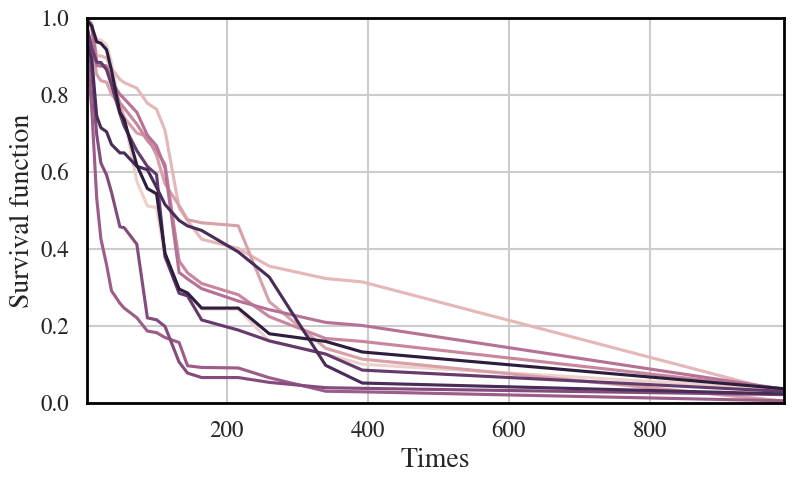

In [8]:
from src import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data, eval_times)
prediction.plot_prediction(surv_pred, "survival")

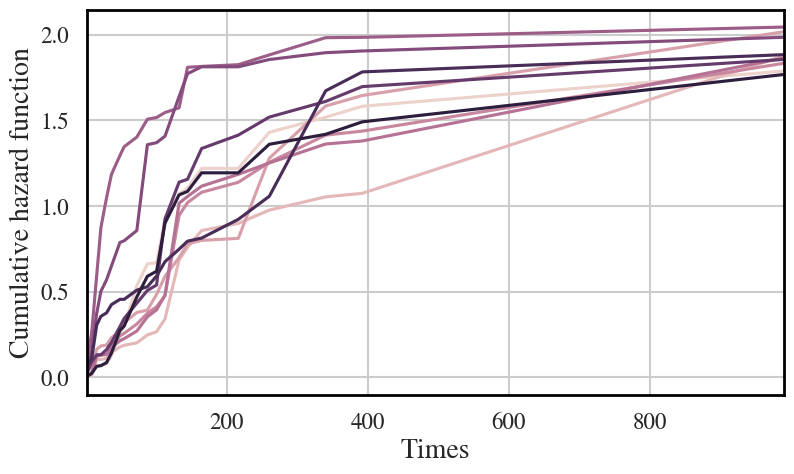

In [9]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, eval_times, type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

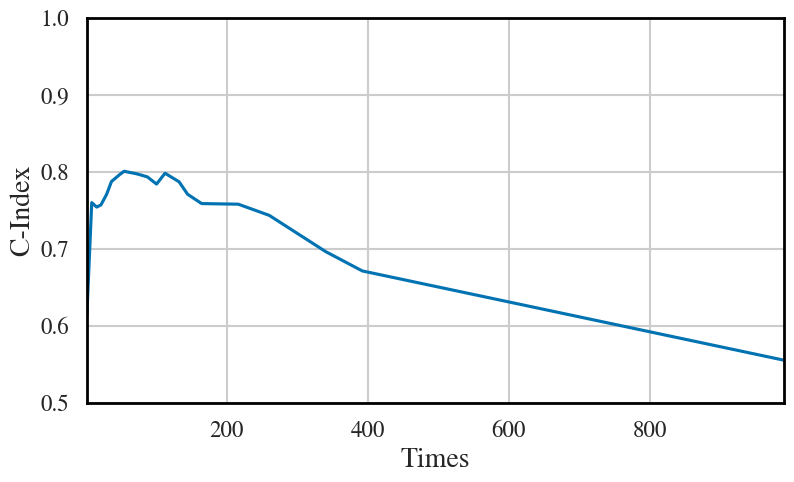

In [11]:
from src import performance
# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index", ylim=(0.5, 1.0))

In [12]:
print(cindex_perf.head(20))

    times      perf
0     1.0  0.611824
1     8.0  0.759655
2    15.0  0.753862
3    21.0  0.756588
4    29.0  0.770218
5    36.0  0.787029
6    48.0  0.796343
7    54.0  0.800318
8    72.0  0.797024
9    87.0  0.793049
10  100.0  0.783735
11  112.0  0.797819
12  132.0  0.786688
13  144.0  0.770559
14  164.0  0.758405
15  216.0  0.757610
16  260.0  0.743071
17  340.0  0.696047
18  392.0  0.670945
19  991.0  0.554918


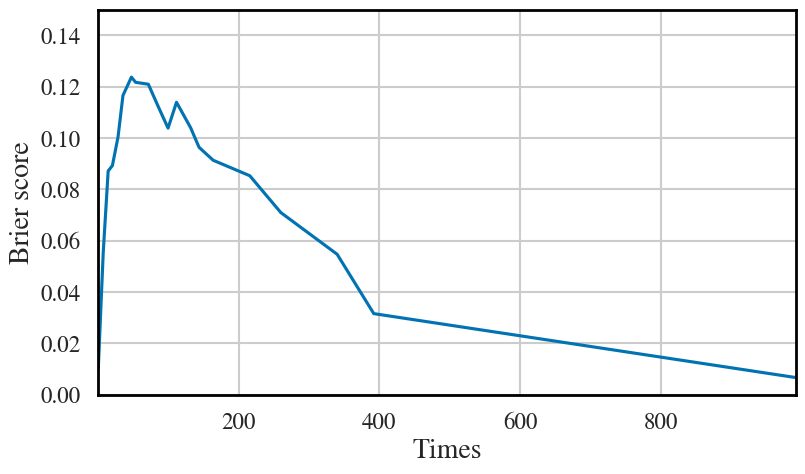

In [13]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score", ylim=(0,0.15))

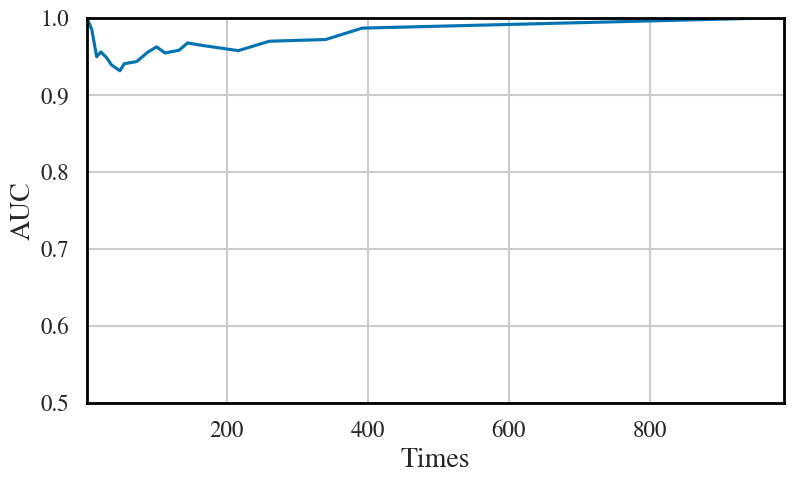

In [14]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc", ylim=(0.5,1))

### Local explaination

In [16]:
from src import local_explaination

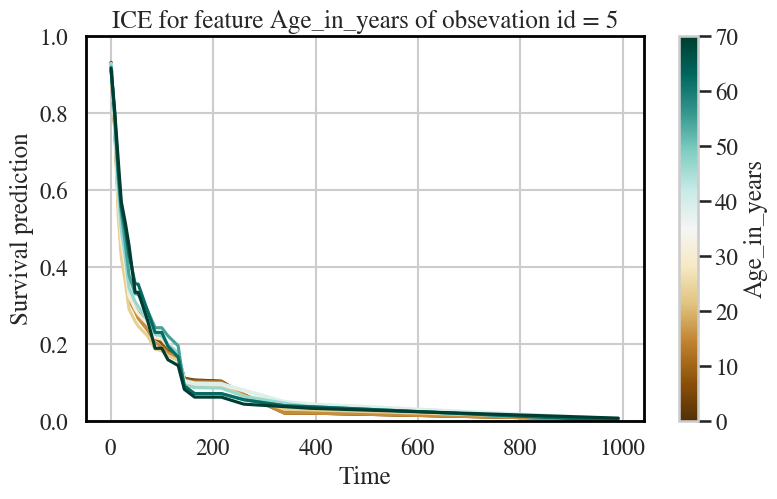

In [17]:
# individual conditional expectation
explained_feature = "Age_in_years"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature, id=5)

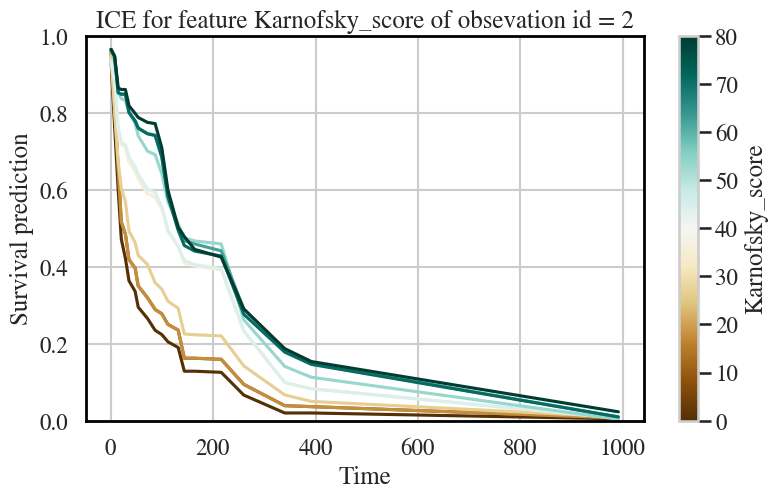

In [18]:
# individual conditional expectation
explained_feature = "Karnofsky_score"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature, id=2)

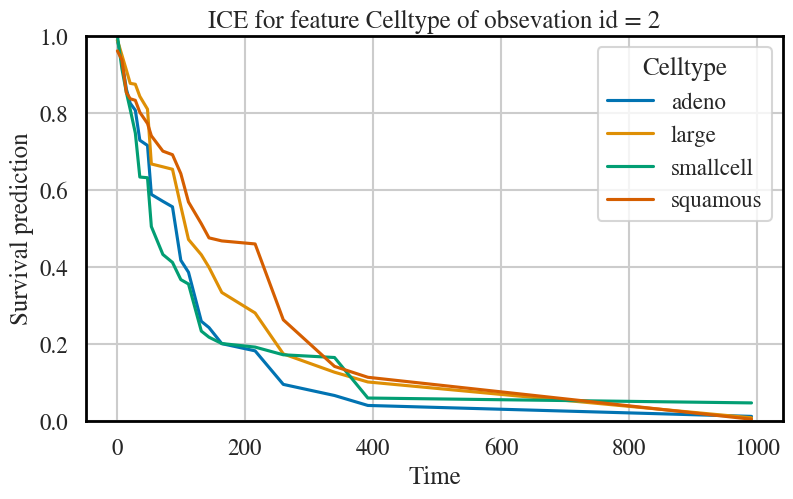

In [19]:
# individual conditional expectation
explained_feature = "Celltype"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)

local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature, id=2)

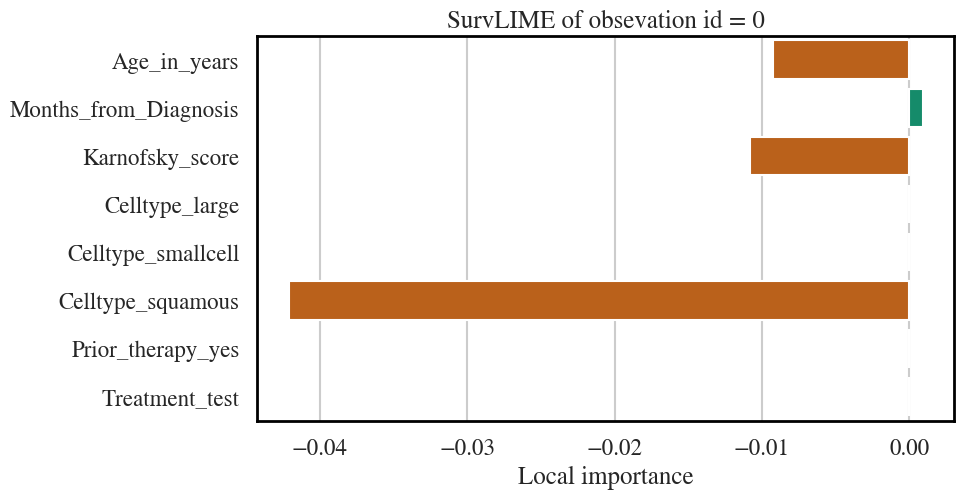

In [20]:
# SurvLIME
SurvLIME_df = local_explaination.SurvLIME(model_explainer, explained_data, id=0)
local_explaination.plot_SurvLIME(SurvLIME_df)

Using 137 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1/1 [02:51<00:00, 171.83s/it]


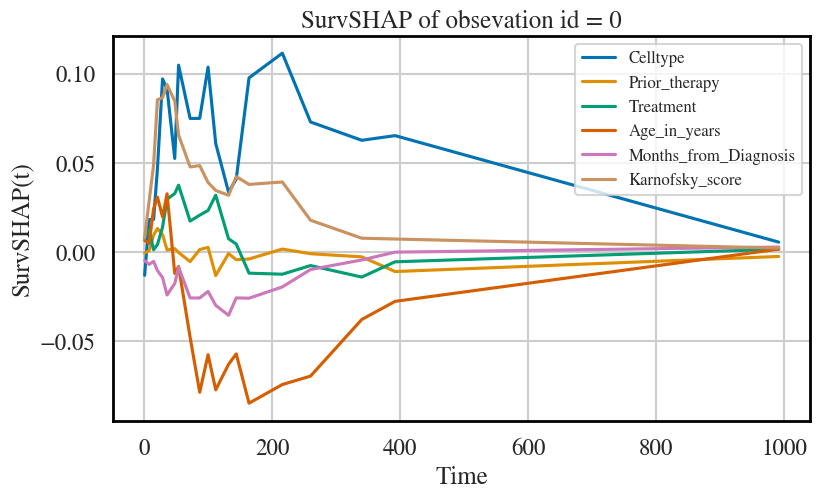

In [21]:
# SurvSHAP
SurvSHAP_df = local_explaination.SurvSHAP(model_explainer, explained_data, id=0)
local_explaination.plot_SurvSHAP(SurvSHAP_df)

### Global explaination

In [23]:
from src import global_explaination

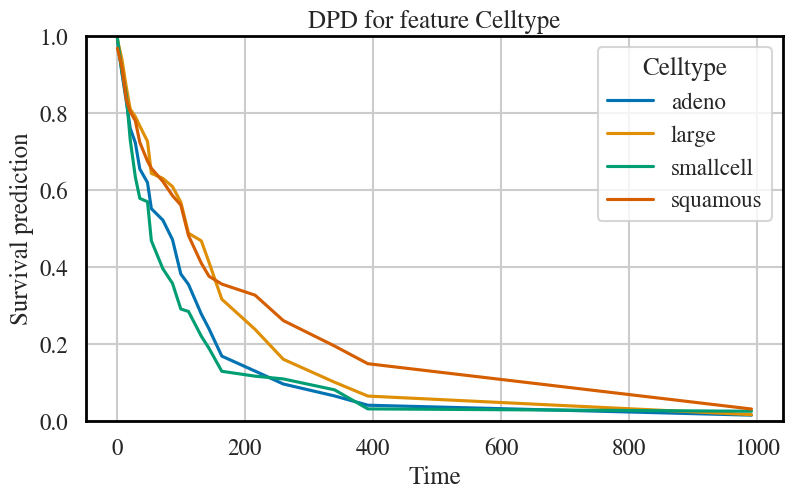

In [24]:
# partial dependence plot
explained_feature = "Celltype"
enc_sel = enc_dict[explained_feature]
PDP_df = global_explaination.partial_dependence_plots(model_explainer, 
                                                      explained_feature, 
                                                      n_sel_samples=100)
global_explaination.plot_PDP(model_explainer, PDP_df, explained_feature)

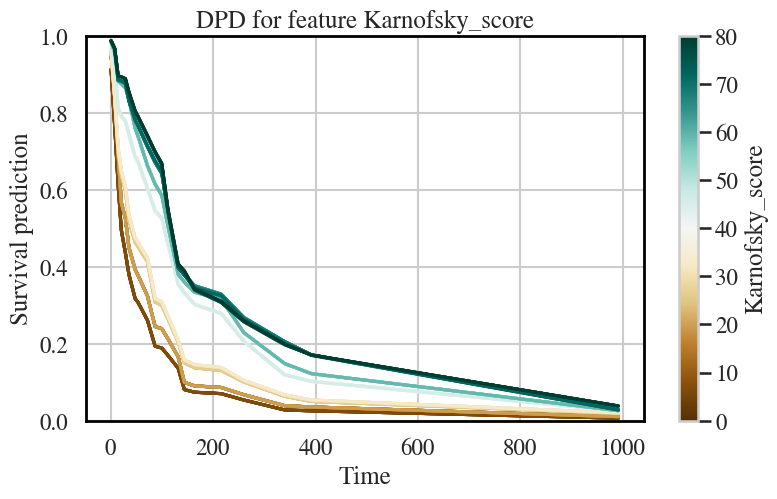

In [25]:
# partial dependence plot
explained_feature = "Karnofsky_score"
PDP_df = global_explaination.partial_dependence_plots(model_explainer, 
                                                      explained_feature, 
                                                      n_sel_samples=10)
global_explaination.plot_PDP(model_explainer, PDP_df, explained_feature)

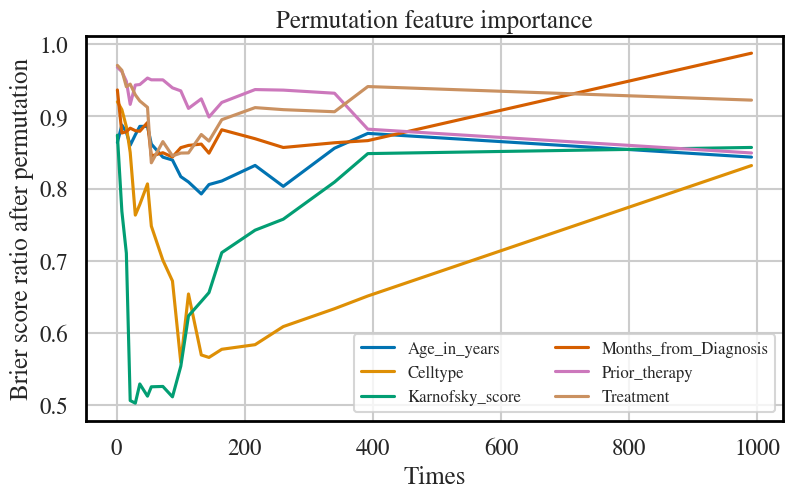

In [26]:
# permuatation feature importance
from src.global_explaination import permutation_feature_importance as PFI
from src.global_explaination import plot_PFI
feat_importance_df = PFI(model_explainer, feats, surv_label, n_perm = 3)
plot_PFI(feat_importance_df, type="ratio")

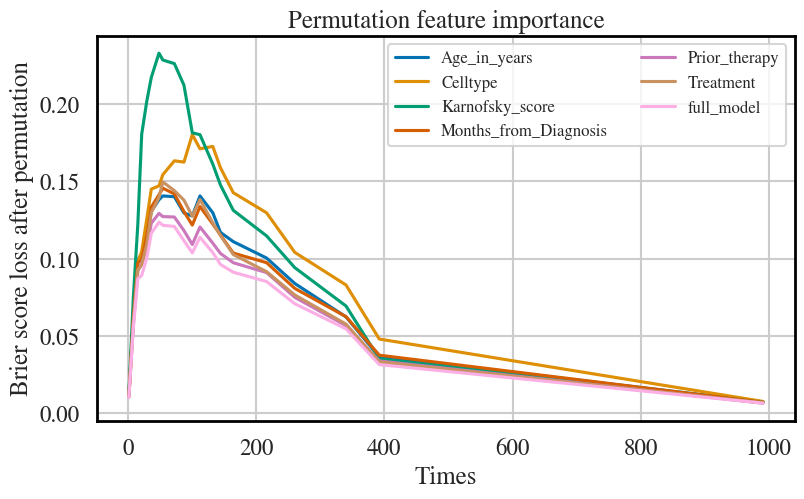

In [27]:
# permuatation feature importance
feat_importance_df = PFI(model_explainer, feats, surv_label, 
                         n_perm = 3, type="loss")
plot_PFI(feat_importance_df, type="loss", legend_loc='upper right')